# Calculating the Tool Center Point (TCP)

In [ ]:
from sympy import symbols, cos, sin, Matrix, pi
import numpy as np
from scipy.optimize import minimize

In [ ]:
# define joint angles
theta1, theta2, theta3, theta4, theta5, theta6 = symbols('theta1 theta2 theta3 theta4 theta5 theta6')

# denavit-Hartenberg parameters for each joint
a = [0, -0.24355, -0.2132, 0, 0, 0]
d = [0.15185, 0, 0, 0.13105, 0.08535, 0.0921]
alpha = [pi/2, 0, 0, pi/2, -pi/2, 0]
theta = [theta1, theta2, theta3, theta4, theta5, theta6]

# transformation matrix function with DH parameters
# Quelle https://de.wikipedia.org/wiki/Denavit-Hartenberg-Transformation ohne DH-Modifizierte Parameter
def dh_matrix(a, d, alpha, theta):
    return Matrix([
        [cos(theta), -sin(theta)*cos(alpha),  sin(theta)*sin(alpha), a*cos(theta)],
        [sin(theta),  cos(theta)*cos(alpha), -cos(theta)*sin(alpha), a*sin(theta)],
        [0,           sin(alpha),             cos(alpha),            d],
        [0,           0,                      0,                     1]
    ])

In [ ]:
# compute the overall transformation matrix
T_TCP = Matrix.eye(4)  # initialize as identity matrix for the multiplication
for i in range(6):
    T_TCP = T_TCP * dh_matrix(a[i], d[i], alpha[i], theta[i])

T_TCP.simplify()
T_TCP

### Starting position of the robot 

**Starting Point of the TCP**

The starting position of the TCP corresponds to the value of $\vec{x}(t)$ at t=0 , which represents the beginning of the trajectory:

$
\vec{x}(0) = \begin{pmatrix}
0.03 \cdot \cos(2\pi \cdot 0) \\
0.03 \cdot \sin(2\pi \cdot 0) \\
0.05 \cdot 0
\end{pmatrix} = \begin{pmatrix}
0.03 \\
0 \\
0
\end{pmatrix}
$

## forward kinematics:

In [ ]:
def dh_transform_matrix(a, d, alpha, theta):
    """
    Compute the Denavit-Hartenberg transformation matrix.
    """
    # Quelle: https://de.wikipedia.org/wiki/Denavit-Hartenberg-Transformation mit Modifizierte DH Parameter
    # siehe auch : https://en.wikipedia.org/wiki/Denavit%E2%80%93Hartenberg_parameters
    return np.array([
        [np.cos(theta), -np.sin(theta), 0, a],
        [np.sin(theta) * np.cos(alpha), np.cos(theta) * np.cos(alpha), -np.sin(alpha), -d * np.sin(alpha)],
        [np.sin(theta) * np.sin(alpha), np.cos(theta) * np.sin(alpha), np.cos(alpha), d * np.cos(alpha)],
        [0, 0, 0, 1]
    ])


def forward_kinematics(theta):
    """
    Calculate the end-effector position using the provided joint angles (theta).
    """
    # DH parameters for each joint: (a, d, alpha, theta)
    dh_params = [
        (0, 0.15185, np.pi/2, theta[0]),
        (-0.24355, 0, 0, theta[1]),
        (-0.2132, 0, 0, theta[2]),
        (0, 0.13105, np.pi/2, theta[3]),
        (0, 0.08535, -np.pi/2, theta[4]),
        (0, 0.0921, 0, theta[5])
    ]
    
    T = np.eye(4)
    for params in dh_params:
        T = np.dot(T, dh_transform_matrix(*params))
    
    # Extract position from the final transformation matrix
    position = T[:3, 3]
    return position


In [ ]:
def rotation_matrix_to_euler_angles(R):
    """
    Convert a rotation matrix to Euler angles.
    """
    sy = np.sqrt(R[0, 0] * R[0, 0] +  R[1, 0] * R[1, 0])
    singular = sy < 1e-6
    if not singular:
        x = np.arctan2(R[2, 1], R[2, 2])
        y = np.arctan2(-R[2, 0], sy)
        z = np.arctan2(R[1, 0], R[0, 0])
    else:
        x = np.arctan2(-R[1, 2], R[1, 1])
        y = np.arctan2(-R[2, 0], sy)
        z = 0
    return np.array([x, y, z])

def forward_kinematics_with_orientation(theta):
    """
    Calculate the end-effector position and orientation using the provided joint angles (theta).
    Orientation is returned as Euler angles.
    """
    # Assuming dh_transform_matrix() is defined as before and calculates the DH transformation matrix.
    # Assuming dh_params is a list of DH parameters for each joint, as defined in a previous example.

    T = np.eye(4)

    dh_params = [
    (0, 0.15185, np.pi/2, theta[0]),
    (-0.24355, 0, 0, theta[1]),
    (-0.2132, 0, 0, theta[2]),
    (0, 0.13105, np.pi/2, theta[3]),
    (0, 0.08535, -np.pi/2, theta[4]),
    (0, 0.0921, 0, theta[5])
    ]
    
    for params in dh_params:
        T = np.dot(T, dh_transform_matrix(*params, theta=params[-1]))

    # Extract position from the final transformation matrix
    position = T[:3, 3]

    # Extract orientation as Euler angles from the rotation part of the matrix
    orientation = rotation_matrix_to_euler_angles(T[:3, :3])

    return position, orientation


## inverse kinematics:
Hier inverse Matrix verwenden? 
https://de.wikipedia.org/wiki/Denavit-Hartenberg-Transformation
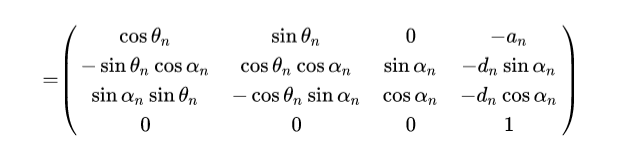

In [ ]:
def objective_function_with_orientation(theta, target_position, constant_orientation):
    """
    Calculate the combined positional and orientational error for the robot end-effector.
    """
    # Calculate the current position and orientation from forward kinematics
    current_pose = forward_kinematics_with_orientation(theta)
    current_position = current_pose[:3]
    current_orientation = current_pose[3:]  # Assuming this function also returns orientation

    # Calculate the positional error
    position_error = np.linalg.norm(current_position - target_position)
    
    # Calculate the orientational error, for example, as the angle between current and desired orientation vectors
    # This is a simplification; in practice, you might use quaternion distances or other measures
    orientation_error = np.linalg.norm(constant_orientation - current_orientation)

    # Combine errors, possibly with weighting factors if needed
    total_error = position_error + orientation_error
    
    return total_error


target_position = np.array([0.03, 0, 0])
initial_guess = np.zeros(6)  # Initial guess for the joint angles

# if orientation remains constant:
constant_orientation = [0, 0, 0]  # in Euler angles (roll, pitch, yaw)

result = minimize(objective_function_with_orientation, initial_guess, args=(target_position,), method='SLSQP')

if result.success:
    optimal_theta = result.x
    print("Optimal joint angles:", np.degrees(optimal_theta))
else:
    print("Optimization was not successful.")

This is a **numerical optimization method** to find joint angles that position the TCP close to the desired starting point of the helical trajectory. It may converge to local minima and depends on the **initial guess** for the joint angles. 
todo:
-  should consider joint limits

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class RobotEnvironment:
    def __init__(self, radius=0.03, height_per_turn=0.05, turns=2, resolution=0.001):
        self.radius = radius
        self.height_per_turn = height_per_turn
        self.turns = turns
        self.resolution = resolution
        
        # Initialize voxel space
        self.voxel_space = np.full((1, 1, 1), -1)  # Placeholder voxel space

    def init_helix(self):
        r = self.radius
        h = self.height_per_turn
        t = np.linspace(0, 2 * np.pi * self.turns, 100)
        helix_x = r * np.cos(t)
        helix_y = r * np.sin(t)
        helix_z = h * t

        # Adjusted setup for a two-channel input
        num_channels = 2  # For voxel_space and TCP position

        # Calculate translation to move helix start to TCP initial position
        translation = np.array([0.1, 0.2, 0.3])  # Example translation

        # Apply translation to helix coordinates
        helix_x_translated = helix_x + translation[0]
        helix_y_translated = helix_y + translation[1]
        helix_z_translated = helix_z + translation[2]

        # Define voxel space dimensions
        x_min, x_max = min(helix_x_translated), max(helix_x_translated)
        y_min, y_max = min(helix_y_translated), max(helix_y_translated)
        z_min, z_max = min(helix_z_translated), max(helix_z_translated)

        # Set voxel space dimensions
        self.x_range = (x_min - 0.005, x_max + 0.005)
        self.y_range = (y_min - 0.005, y_max + 0.005)
        self.z_range = (z_min - 0.005, z_max + 0.005)

        # Initialize voxel space with the adjusted dimensions
        self.voxel_space = np.full((int((x_max - x_min) / self.resolution) + 1,
                                    int((y_max - y_min) / self.resolution) + 1,
                                    int((z_max - z_min) / self.resolution) + 1), -1)

        # Mark the voxels on the helix path
        for i in range(len(helix_x_translated)):
            x_idx = int(round((helix_x_translated[i] - self.x_range[0]) / self.resolution))
            y_idx = int(round((helix_y_translated[i] - self.y_range[0]) / self.resolution))
            z_idx = int(round((helix_z_translated[i] - self.z_range[0]) / self.resolution))

            if 0 <= x_idx < self.voxel_space.shape[0] and 0 <= y_idx < self.voxel_space.shape[1] and 0 <= z_idx < self.voxel_space.shape[2]:
                if i == len(helix_x_translated) - 1:  # last helix point
                    self.voxel_space[x_idx, y_idx, z_idx] = 1
                else:
                    self.voxel_space[x_idx, y_idx, z_idx] = 0  # helix path

    def render(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot helix path
        helix_path_indices = np.argwhere(self.voxel_space == 0)
        ax.scatter(helix_path_indices[:, 0], helix_path_indices[:, 1], helix_path_indices[:, 2], c='b', label='Helix Path')

        # Plot helix end points
        helix_end_indices = np.argwhere(self.voxel_space == 1)
        ax.scatter(helix_end_indices[:, 0], helix_end_indices[:, 1], helix_end_indices[:, 2], c='r', label='Helix End Points')

        ax.set_xlabel('X Index')
        ax.set_ylabel('Y Index')
        ax.set_zlabel('Z Index')
        ax.set_title('3D Plot of the Voxel Space')
        ax.legend()
        plt.show()

# Test the RobotEnvironment class
env = RobotEnvironment()
env.init_helix()
env.render()

